# CS 109A/STAT 121A/AC 209A/CSCI E-109A

## Standard Section 7: Real World Classification Tradeoffs

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders: Albert Wu, Nathaniel Burbank<br/>**
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine** 

<center>**Download this notebook from the CS109 repo or here:**</center>
<center>**http://bit.ly/109_S7T**</center>

In this section we will be covering real-world issues that arise with building classifiers. Specifically we will be discussing how to work with ROC curves, strategies to handle imbalanced datasets, and why the end metric that you’re actually interested in should be considered during model selection (i.e., you should think beyond just accuracy and classification statistics). 

Specifically, we will: 
    
    1. Apply and interpret an ROC curve on a logistic classifier on the Titanic Dataset 
    2. Fit a logistic regression model to a (simulated) dataset of past customer purchases, and see if we can predict whether they’re pregnant
    3. Build a classifier to predict cancer cases, and discover that overall prediction accuracy is often only part of the story in real life

In [149]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import metrics, datasets
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

---

## Review ROC Curves (Titanic Example) 

Let’s start by load in the Titanic Dataset that we’ve become very familiar with over the last few sections, and fit a standard logistic regression classifier. 

In [150]:
import statsmodels.formula.api as sm
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [151]:
# Subset to only cols we want
titanic = titanic[['sex', 'age', 'class', 'survived']]

# Rename 'class' col to 'pclass' to avoid namespace issues
titanic.columns = ['sex', 'age', 'pclass', 'survived']

#Drop any row with NA values in any col in dataframe
titanic = titanic.dropna()

is_female = pd.get_dummies(titanic.sex)['female']
pclass_coded = pd.get_dummies(titanic.pclass)[['First','Second']]

titanic_c = pd.concat([is_female,pclass_coded,titanic[['age','survived']]],axis=1)
titanic_c.head()

,female,First,Second,age,survived
0,0,0,0,22.0,0
1,1,1,0,38.0,1
2,1,0,0,26.0,1
3,1,1,0,35.0,1
4,0,0,0,35.0,0


In [152]:
logit = LogisticRegression(C=1000000)
train, test =  train_test_split(titanic_c, test_size=.2, random_state=123)
X_train = train.iloc[:,:4]
y_train = train.survived

X_test = test.iloc[:,:4]
y_test = test.survived

logit.fit(X_train, y_train) 
print(logit.score(X_test,y_test))

0.755244755245


Overall Accuracy is about 75%. Let’s fit an ROC curve…

In [153]:
logit.coef_

array([[ 2.66233164,  2.5962139 ,  1.13821077, -0.03594795]])

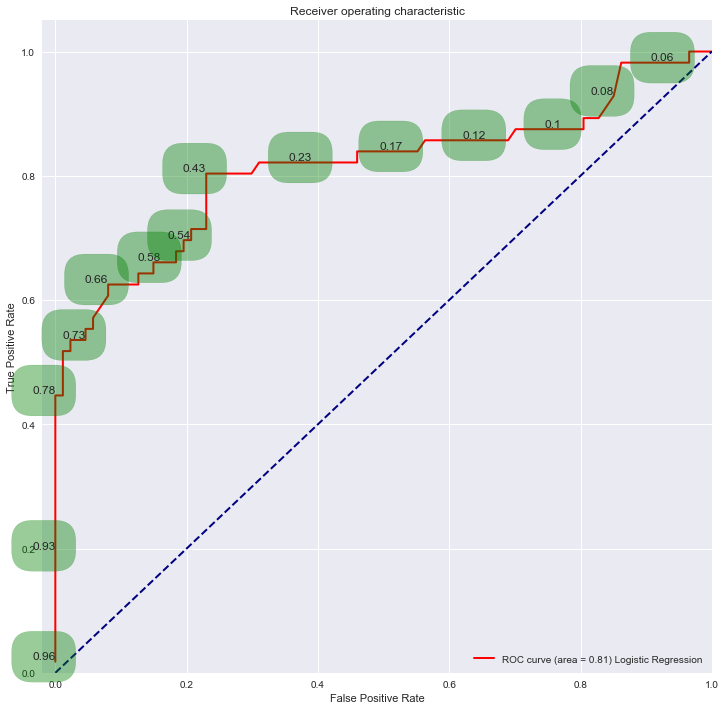

In [154]:
preds = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)

plt.figure(figsize=(12, 12))
lw = 2
roc_auc = metrics.auc(fpr, tpr)
roc_auc_2 = metrics.auc(fpr_2, tpr_2)
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f) Logistic Regression' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
label_kwargs = {}
label_kwargs['bbox'] = dict(
        boxstyle='round,pad=1.7', alpha=0.4, color = 'green'
    )
for k in range(0, fpr.shape[0],5):
            threshold = str(np.round(thresholds[k], 2))
            plt.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs, fontsize = 12, ha = 'right', va = 'bottom')
plt.show()

What does the red line actually mean in this scenario? How might our model be different if we were at a different position on the line? 

In [155]:
predicted = logit.predict(test[['female','First','Second','age']])
threshold = .5
#predicted = threshold < pd.DataFrame(logit.predict_proba(test[['female','First','Second','age']]))[1]
expected = test['survived']
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.80      0.79      0.80        87
          1       0.68      0.70      0.69        56

avg / total       0.76      0.76      0.76       143



We have two ways to create our confusion matrix:

**Method 1:**

In [156]:
conf_mat = confusion_matrix(expected, predicted)
conf_df = pd.DataFrame(conf_mat, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df

,y_hat=0,y_hat = 1
y=0,69,18
y=1,17,39


**Method 2:**

In [157]:
pd.crosstab(expected,predicted,margins=True,dropna=False)

col_0,0,1,All
survived,,,
0,69,18,87
1,17,39,56
All,86,57,143


The row totals (87 died, 56 survived) above represent the *true* number of individuals in our test set that survived or perished on the titanic. The columns represent what our model predicted. Per the precision stats above, our model is getting about 3/4  of the test set correctly categorized, but still has a lot of false negatives and false positives.

However, we can play with the discretization threshold for different outcomes:

In [158]:
threshold = .75
predicted = threshold < pd.DataFrame(logit.predict_proba(test[['female','First','Second','age']]))[1]
expected = test['survived']
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.76      0.99      0.86        87
          1       0.97      0.52      0.67        56

avg / total       0.84      0.80      0.79       143



With this dataset, there’s probably no real reason we’d want to optimize for anything but overall accuracy. (So we’d want our classifier to be in the upper left-hand corner of the ROC curve.) In the next example the situation is quite different… 

**Now, what if we wanted to find the *true positive rate*, *true negative rate*, and the *false positive rate* of our fitted classifier, and how the *false positive rate* is related to its true positive and true negative rate?**

In [159]:
print("True Positive Rate for Fitted: ", float(conf_mat[1][1])/(conf_mat[1][1]+ conf_mat[1][0]))
print("True Negative Rate for Fitted: ", float(conf_mat[0][0])/(conf_mat[0][0] + conf_mat[0][1]))
print("False Positive Rate for Fitted: ", float(conf_mat[0][1])/(conf_mat[0][1] + conf_mat[0][0]))

True Positive Rate for Fitted:  0.696428571429
True Negative Rate for Fitted:  0.793103448276
False Positive Rate for Fitted:  0.206896551724


TNR + FPR = 1 for the first part, but there is NO good relation for the FPR and the TPR as they cannot be used to predict each other. There is not direct formula going from one to the other!

**Now suppose we wanted our FPR to be set at most at 0.3. What is the highest TPR we can get? What is the threshold at that point?**

In [160]:
print("Highest TPR with FPR set at 0.3: ", tpr[np.min([i for i, x in enumerate(fpr) if x>=0.3])])
print("Corresponding Threshold: ",thresholds[np.min([i for i, x in enumerate(fpr) if x>=0.3])])


Highest TPR with FPR set at 0.3:  0.821428571429
Corresponding Threshold:  0.289442234886


---

## Review oversampling (Pregnancy prediction example) 

This dataset was adapted from an example in *Data Smart* by John Foreman. It's a dataset of indicator variables about customer purchases in the past six-months for a (simulated) large retailer. Ala the scandal that Target [experienced](https://www.forbes.com/sites/kashmirhill/2012/02/16/how-target-figured-out-a-teen-girl-was-pregnant-before-her-father-did/#3ceb310b6668) a few years back, the question is, can you predict customer’s pregnancy status based on their purchases alone? 

Separate training and test samples (1000 observations each) are provided:

In [161]:
store_train = pd.read_csv("https://raw.githubusercontent.com/nathanielburbank/CS109/master/s7_data/store_data_train.csv")
store_test = pd.read_csv("https://raw.githubusercontent.com/nathanielburbank/CS109/master/s7_data/store_data_test.csv")
store_train.head()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes,PREGNANT
0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [162]:
store_train.groupby("PREGNANT").count()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes
PREGNANT,,,,,,,,,,,,,,
0,500,500,500,500,500,500,500,500,500,500,500,500,500,500
1,500,500,500,500,500,500,500,500,500,500,500,500,500,500


In [163]:
store_test.groupby("PREGNANT").count()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes
PREGNANT,,,,,,,,,,,,,,
0,940,940,940,940,940,940,940,940,940,940,940,940,940,940
1,60,60,60,60,60,60,60,60,60,60,60,60,60,60


Note that only ~4% of adult women are pregnant at any given time, so it’s a very imbalanced classification problem. However, we’ve significantly *oversampled* observations of pregnant women in our training data so as to ensure that our model does a good job of identifying true positives. What’s the downside of this approch? 

Anyway, let's build a logistic regression and evaluate the ROC curve...

In [164]:
logit = LogisticRegression(C=1000000)
X_train = store_train.iloc[:,:14]
y_train = store_train.PREGNANT

X_test = store_test.iloc[:,:14]
y_test = store_test.PREGNANT

logit.fit(X_train, y_train) 
print(logit.score(X_test,y_test))

0.887


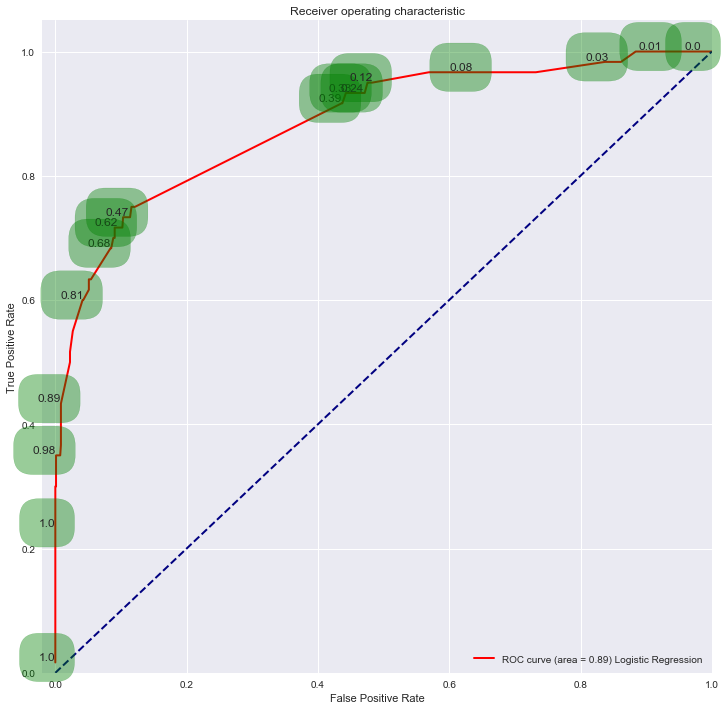

In [165]:
preds = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)

plt.figure(figsize=(12, 12))
lw = 2
roc_auc = metrics.auc(fpr, tpr)
roc_auc_2 = metrics.auc(fpr_2, tpr_2)
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f) Logistic Regression' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
label_kwargs = {}
label_kwargs['bbox'] = dict(
        boxstyle='round,pad=1.6', alpha=0.4, color = 'green'
    )
for k in range(0, fpr.shape[0],5):
            threshold = str(np.round(thresholds[k], 2))
            plt.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs, fontsize = 12, ha = 'right', va = 'bottom')
plt.show()

In [166]:
predicted = logit.predict(X_test)
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.98      0.90      0.94       940
          1       0.31      0.73      0.44        60

avg / total       0.94      0.89      0.91      1000



Let us again use the two methods:

**Method 1:**

In [167]:
conf_mat2 = confusion_matrix(y_test, predicted)
conf_df2 = pd.DataFrame(conf_mat2, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df2

,y_hat=0,y_hat = 1
y=0,843,97
y=1,16,44


**Method 2:**

In [168]:
pd.crosstab(y_test,predicted,margins=True,dropna=False)

col_0,0,1,All
PREGNANT,,,
0,843,97,940
1,16,44,60
All,859,141,1000


**Again, as in the last problem, what if we wanted to find the *true positive rate*, *true negative rate*, and the *false positive rate* of our fitted classifier, and how the *false positive rate* is related to its true positive and true negative rate?**

In [169]:
print("True Positive Rate for Fitted: ", float(conf_mat2[1][1])/(conf_mat2[1][1]+ conf_mat2[1][0]))
print("True Negative Rate for Fitted: ", float(conf_mat2[0][0])/(conf_mat2[0][0] + conf_mat2[0][1]))
print("False Positive Rate for Fitted: ", float(conf_mat2[0][1])/(conf_mat2[0][1] + conf_mat2[0][0]))

True Positive Rate for Fitted:  0.733333333333
True Negative Rate for Fitted:  0.896808510638
False Positive Rate for Fitted:  0.103191489362


**Now suppose we wanted our FPR to be set at most at 0.3. What is the highest TPR we can get? What is the threshold at that point?**

In [170]:
print("Highest TPR with FPR set at 0.3: ", tpr[np.min([i for i, x in enumerate(fpr) if x>=0.3])])
print("Corresponding Threshold: ",thresholds[np.min([i for i, x in enumerate(fpr) if x>=0.3])])


Highest TPR with FPR set at 0.3:  0.916666666667
Corresponding Threshold:  0.389117717378


Note that while our model does a great job of identifying true-positives (pregnant women) it comes at the cost of increased false-positives. Depending on what we were actually going to do this data, we might prefer one or another, and build a model that chose a different optimum on the ROC curve. 

---

# Cancer Prediction with Dropping Missing Values and Mean Imputation

This dataset is somewhat similar to the homework in that we have a low number of treated cases compared to the untreated cases. We also have missing values. We will tackle the missing values through two methods.

In [102]:
#Load and inspect the data
data = pd.read_csv('https://raw.githubusercontent.com/albertw1/data/master/final_data4.csv', low_memory=False)  # low memory is set false for better type inference
data.head()

,Incidence,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
0,1,-0.00184,0.02440,1.090,0.948,NaN,-1.560,-1.580,-0.664,0.568,-0.4590,-1.200,0.0957,-0.210,-0.72900,0.575,NaN
1,1,-0.04980,0.00719,1.070,0.923,0.472,-1.690,-1.650,0.594,0.205,-0.2810,-1.280,-0.1140,-0.147,0.36300,1.070,1.460
2,1,-0.12000,0.00218,0.141,0.140,0.288,-0.428,-0.538,NaN,-0.433,0.1690,-0.678,-0.7380,0.271,0.78800,0.779,0.389
3,1,-0.11600,0.08790,0.324,0.277,0.399,-0.336,-0.336,NaN,-0.168,0.2120,-0.689,0.5580,0.188,-0.00104,0.178,0.546
4,1,-0.06150,-0.26000,0.871,0.755,NaN,-1.430,-1.390,-0.796,-0.422,-0.0827,-1.380,-0.0306,0.605,NaN,NaN,NaN


The first column represents our indicator of Cancer, which is our response variable. 

In [103]:
data.shape

(15474, 17)

### Dropping NA values

We wish to use the first method on homework 7, which is to drop the missing values.

In [110]:
data1 = data.copy()

# Drop out NAN's by row
data1.dropna(inplace=True)
# Splitting our data
np.random.seed(9001)
msk = np.random.rand(len(data1)) < 0.75
data_train = data1[msk]
data_test = data1[~msk]

X_train = data_train.loc[:, data_train.columns != 'Incidence']
X_test  = data_test.loc[:, data_test.columns != 'Incidence']
y_train = data_train['Incidence'].values
y_test  = data_test['Incidence'].values

In [111]:
data1.shape

(6563, 17)

Now lets do logistic regression on the data.

In [112]:
logregcv = LogisticRegressionCV()
logregcv.fit(X_train, y_train)
y_hat_train = logregcv.predict(X_train)
y_hat_test = logregcv.predict(X_test)
print("Train accuracy for NA Drop: ", accuracy_score(y_train, y_hat_train))
print("Test accuracy for NA Drop: ", accuracy_score(y_test, y_hat_test))

Train accuracy for NA Drop:  0.992140266022
Test accuracy for NA Drop:  0.98750780762


We again rely on the confusion matrix to gain a clearer picture of how the classification did.

In [113]:
conf_mat_1 = confusion_matrix(y_test, y_hat_test)
conf_df_1 = pd.DataFrame(conf_mat_1, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df_1

,y_hat=0,y_hat = 1
y=0,1580,0
y=1,20,1


In [114]:
print("True Positive Rate for Part 1: ", float(conf_mat_1[1][1])/(conf_mat_1[1][1]+ conf_mat_1[1][0]))

True Positive Rate for Part 1:  0.047619047619


We can see that prediction accuracy is only part of the story. Most of the high predictive power is due to predicting the negative cases. We perform very bad for the positive case, with only one right prediction of Cancer out of 21. 

### Mean Imputation Method

For this method, we will use the mean of the non-missing entries of each column to impute, or predict the missing values within that column, across our entire dataset. 

In [124]:
data2 = data.copy()
imputer = Imputer( strategy='mean')
data2 = imputer.fit_transform(data2.values)
msk = np.random.rand(len(data2)) < 0.75
data_train2 = data2[msk]
data_test2 = data2[~msk]

X_train2 = data_train2[:, 1:]
y_train2 = data_train2[:, 0]
X_test2  = data_test2[:, 1:]
y_test2  = data_test2[:, 0]

In [125]:
logregcv = LogisticRegressionCV()
logregcv.fit(X_train2, y_train2)
y_hat_train2 = logregcv.predict(X_train2)
y_hat_test2 = logregcv.predict(X_test2)
print("Train accuracy for Mean Imputation: ", accuracy_score(y_train2, y_hat_train2))
print("Test accuracy for Mean Imputation: ", accuracy_score(y_test2, y_hat_test2))

Train accuracy for Mean Imputation:  0.990138912708
Test accuracy for Mean Imputation:  0.991343126967


The test accuracy is better than before, but let us see how well it does for the cancer classification.

In [128]:
conf_mat_2 = confusion_matrix(y_test2, y_hat_test2)
conf_df_2 = pd.DataFrame(conf_mat_2, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df_2

,y_hat=0,y_hat = 1
y=0,3777,2
y=1,31,2


In [129]:
print("True Positive Rate for Part 2: ", float(conf_mat_2[1][1])/(conf_mat_2[1][1]+ conf_mat_2[1][0]))

True Positive Rate for Part 2:  0.0606060606061


This does a bit better than before, but still missed a ton of cases for the positives!